This notebook automatically does the following after a nnU-Net model has been trained, and the results have been zipped and downloaded from the fileserver:
1. Make convergence plots of each fold
2. Analyse various metrics (mean, std, max, min) of each fold and save

In [6]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
from util import management as mana
from util import constants as con

# Fill in task specifics
task = con.TASK_613
config = con.CONFIG_FULL
trainer = con.CLASSIC
folds = [0,1,2,3,4]
labels = [1]

c:\Users\ikke_\OneDrive\Documenten\Thesis\MasterThesis\Code


Setting the necessary variables and useful paths

In [7]:
thesis_dir = "C:\\Users\\ikke_\\OneDrive\\Documenten\\Thesis"
results_dir = f"{thesis_dir}\\Results"
output_dir = f"{thesis_dir}\\MasterThesis\\Latex"

fig_path = os.path.join(output_dir, "figures", str(task))
save_res_path = os.path.join(output_dir, "results", str(task))
res_path = os.path.join(results_dir, f"{task}", config, trainer)

# Creates figures path
if not(os.path.exists(fig_path)):
    os.mkdir(fig_path)
    os.mkdir(save_res_path)

# Unzip all the folders 
mana.unzip_all_folders(res_path)

def create_fold_path(fold):
    return f"fold_{fold}_dir"

Create the convergence graph of each fold

0


C:\Users\ikke_\AppData\Local\Temp\ipykernel_21612\229429129.py:28: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(f"{fig_path}/convergence_single_fold_{task}_{config}_{trainer}_{fold}", dpi=300, figsize=(8,5))


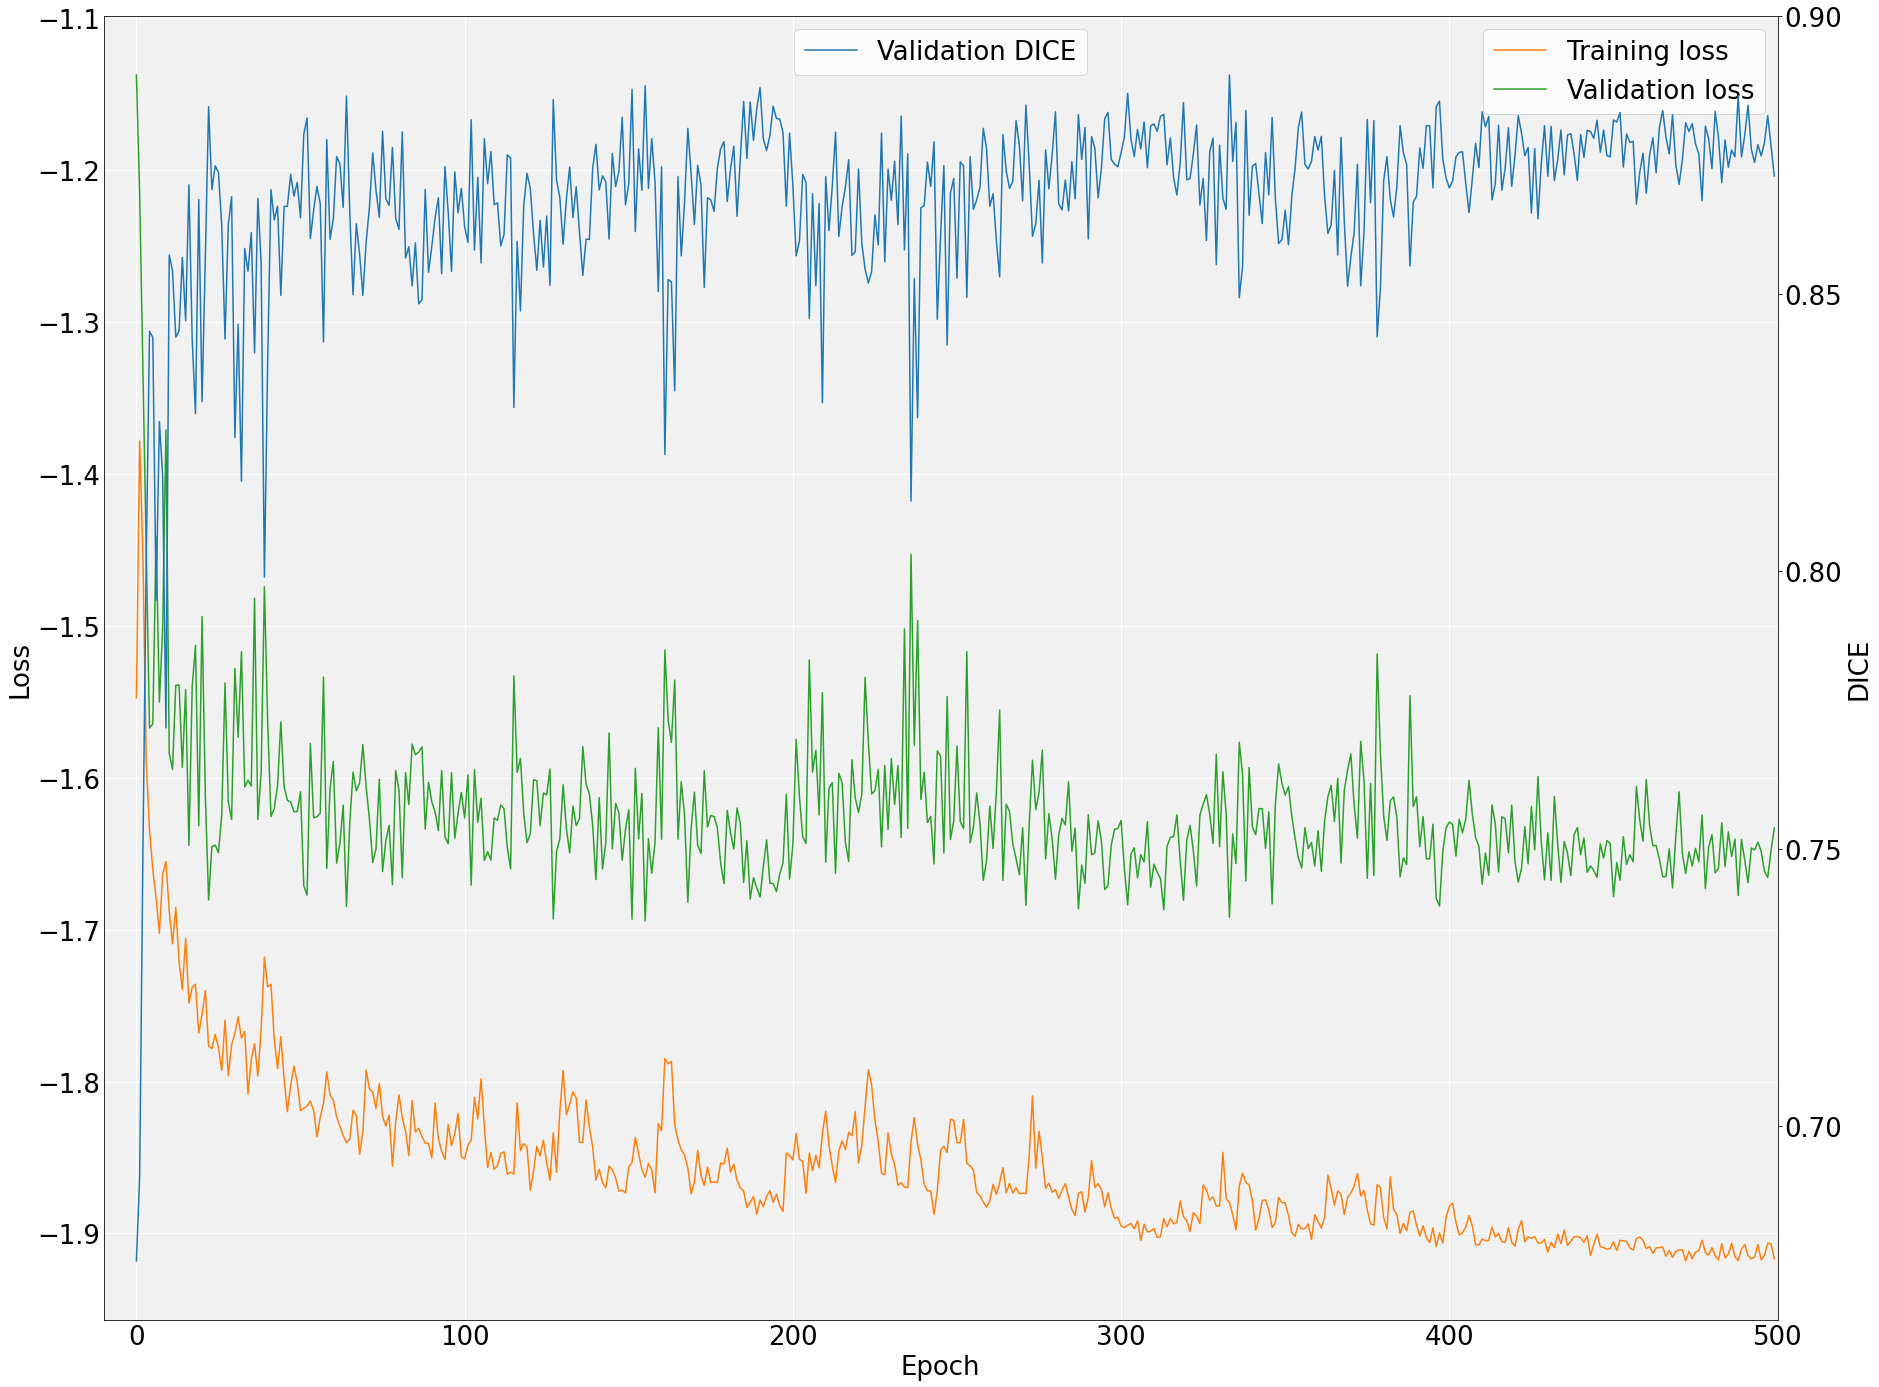

1


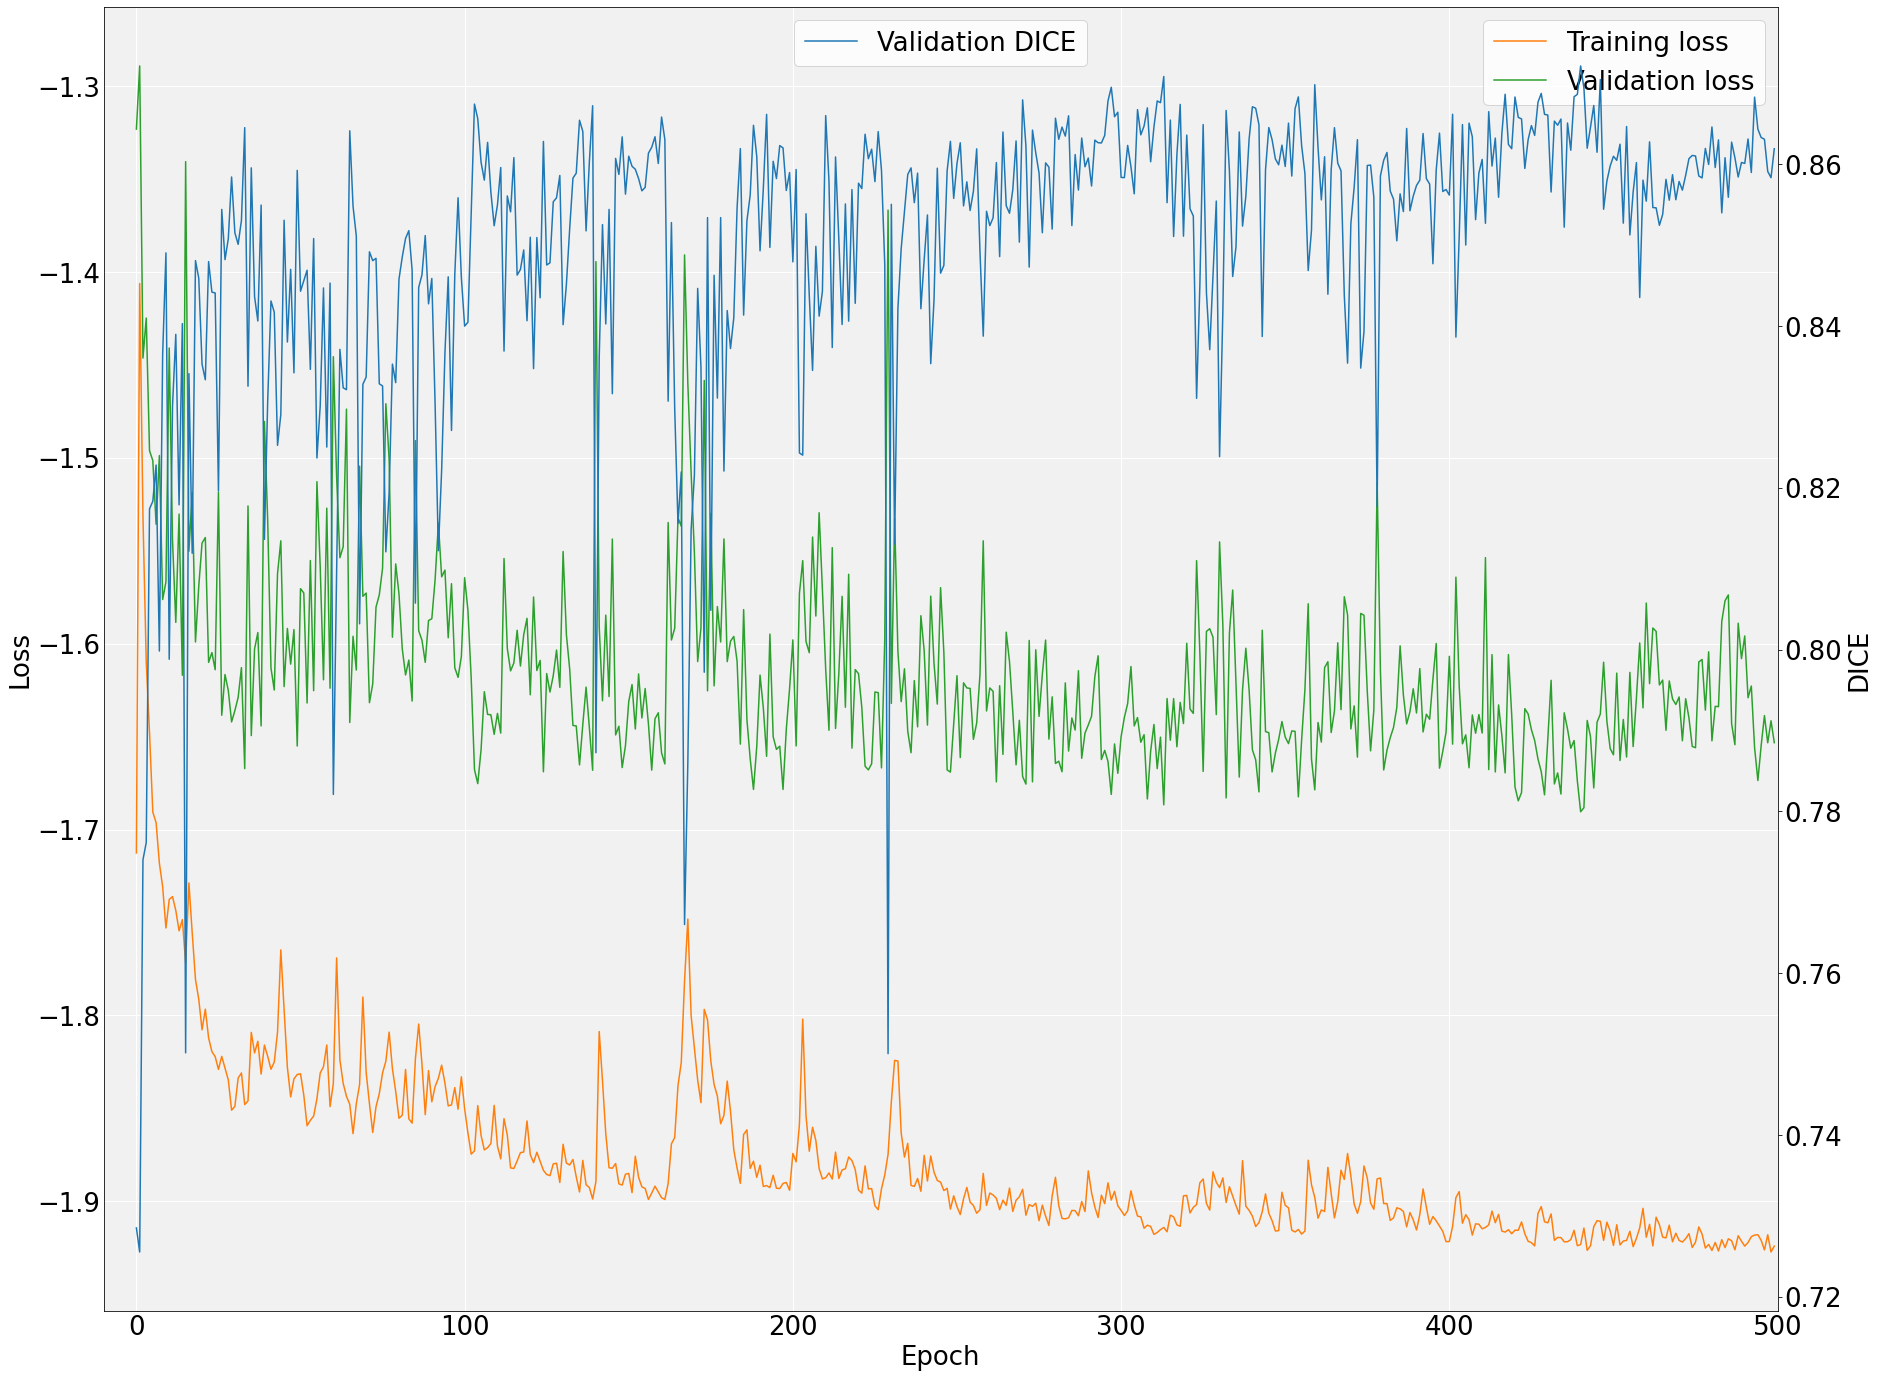

2


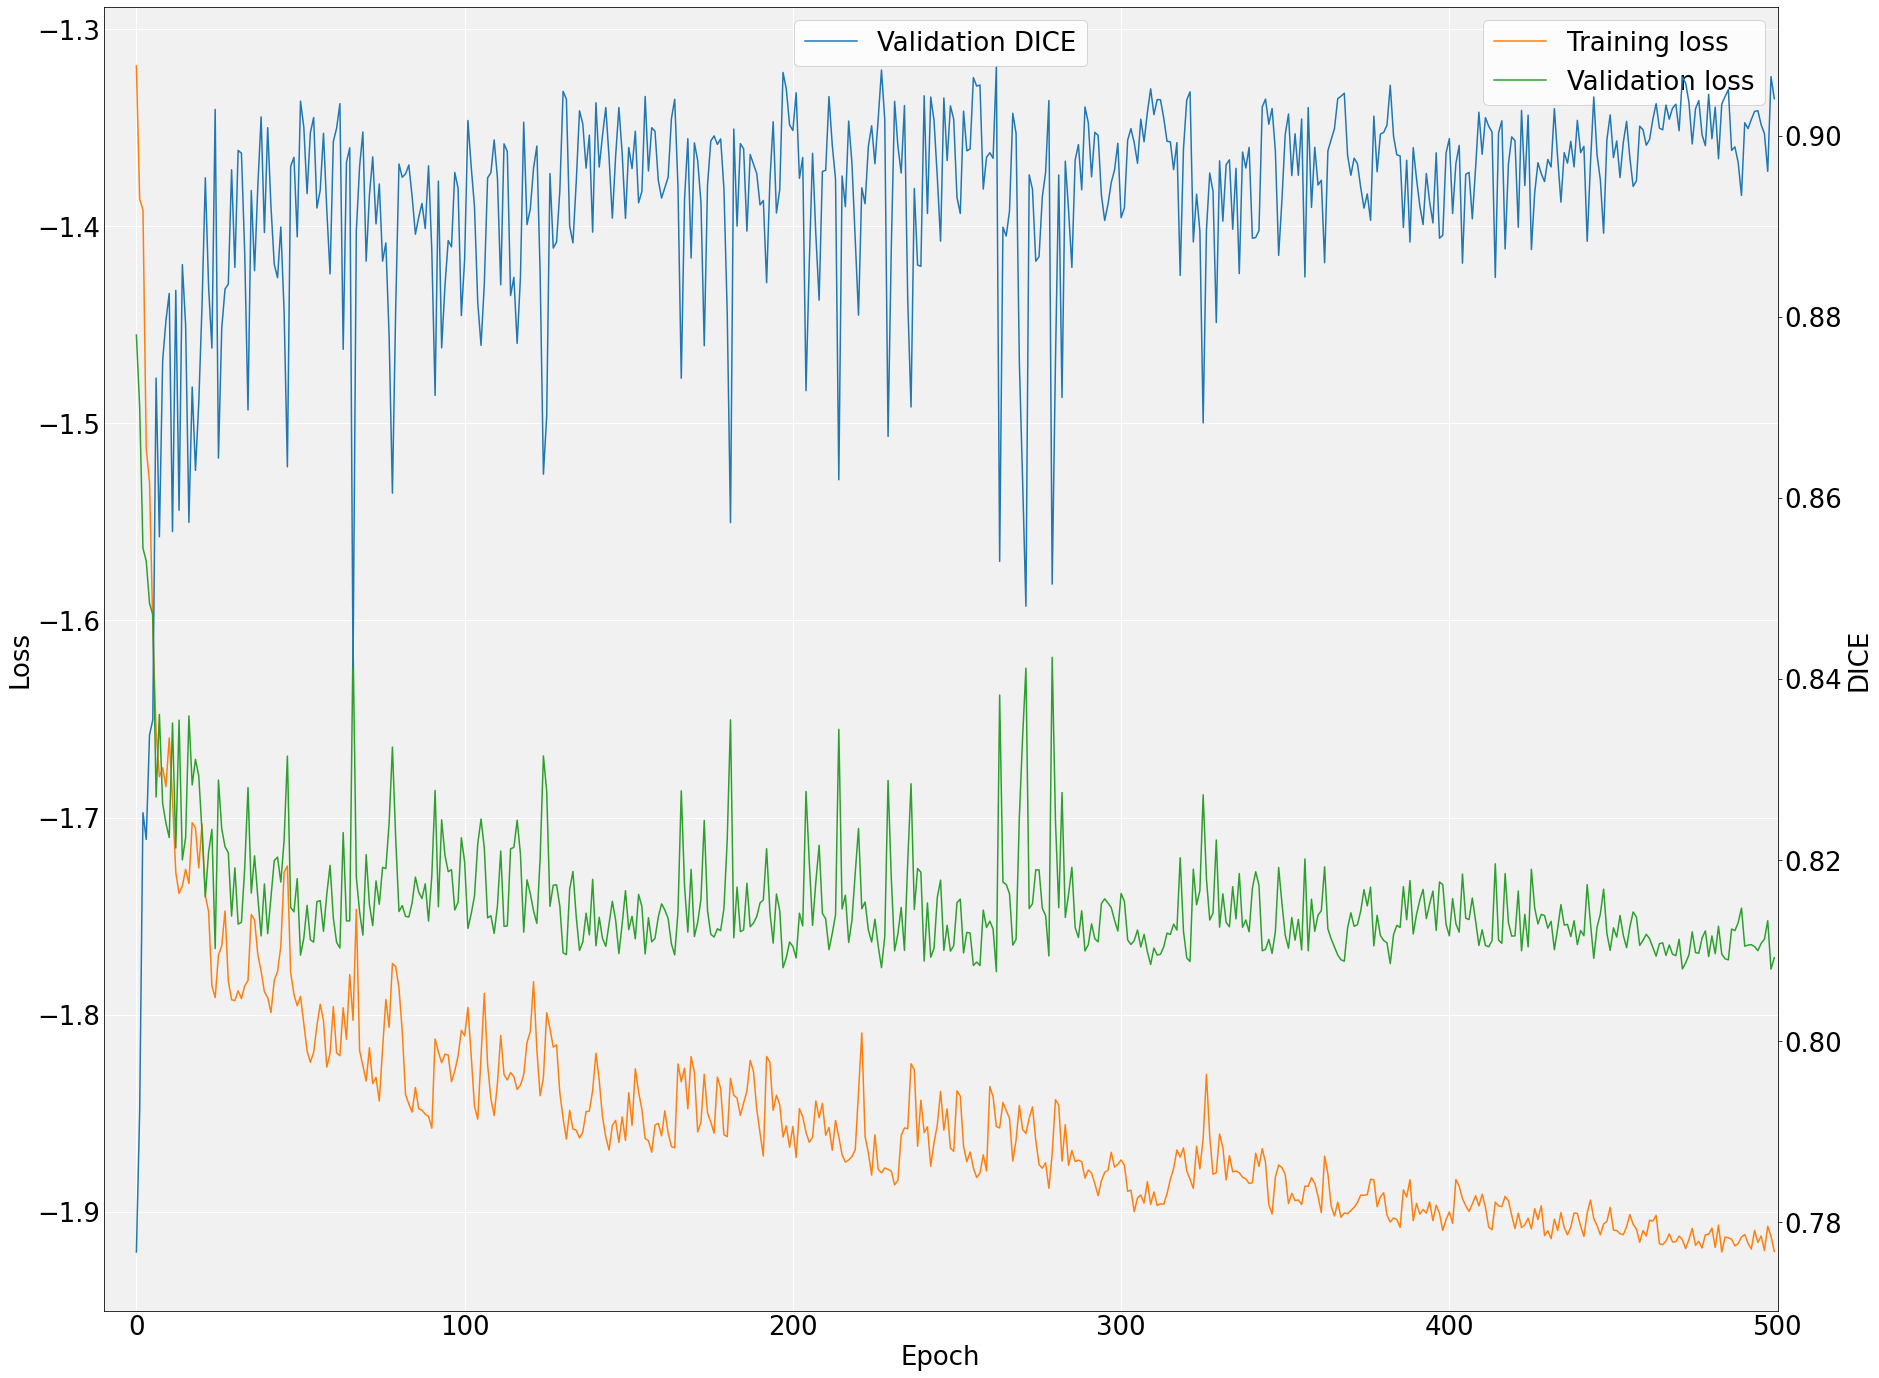

3


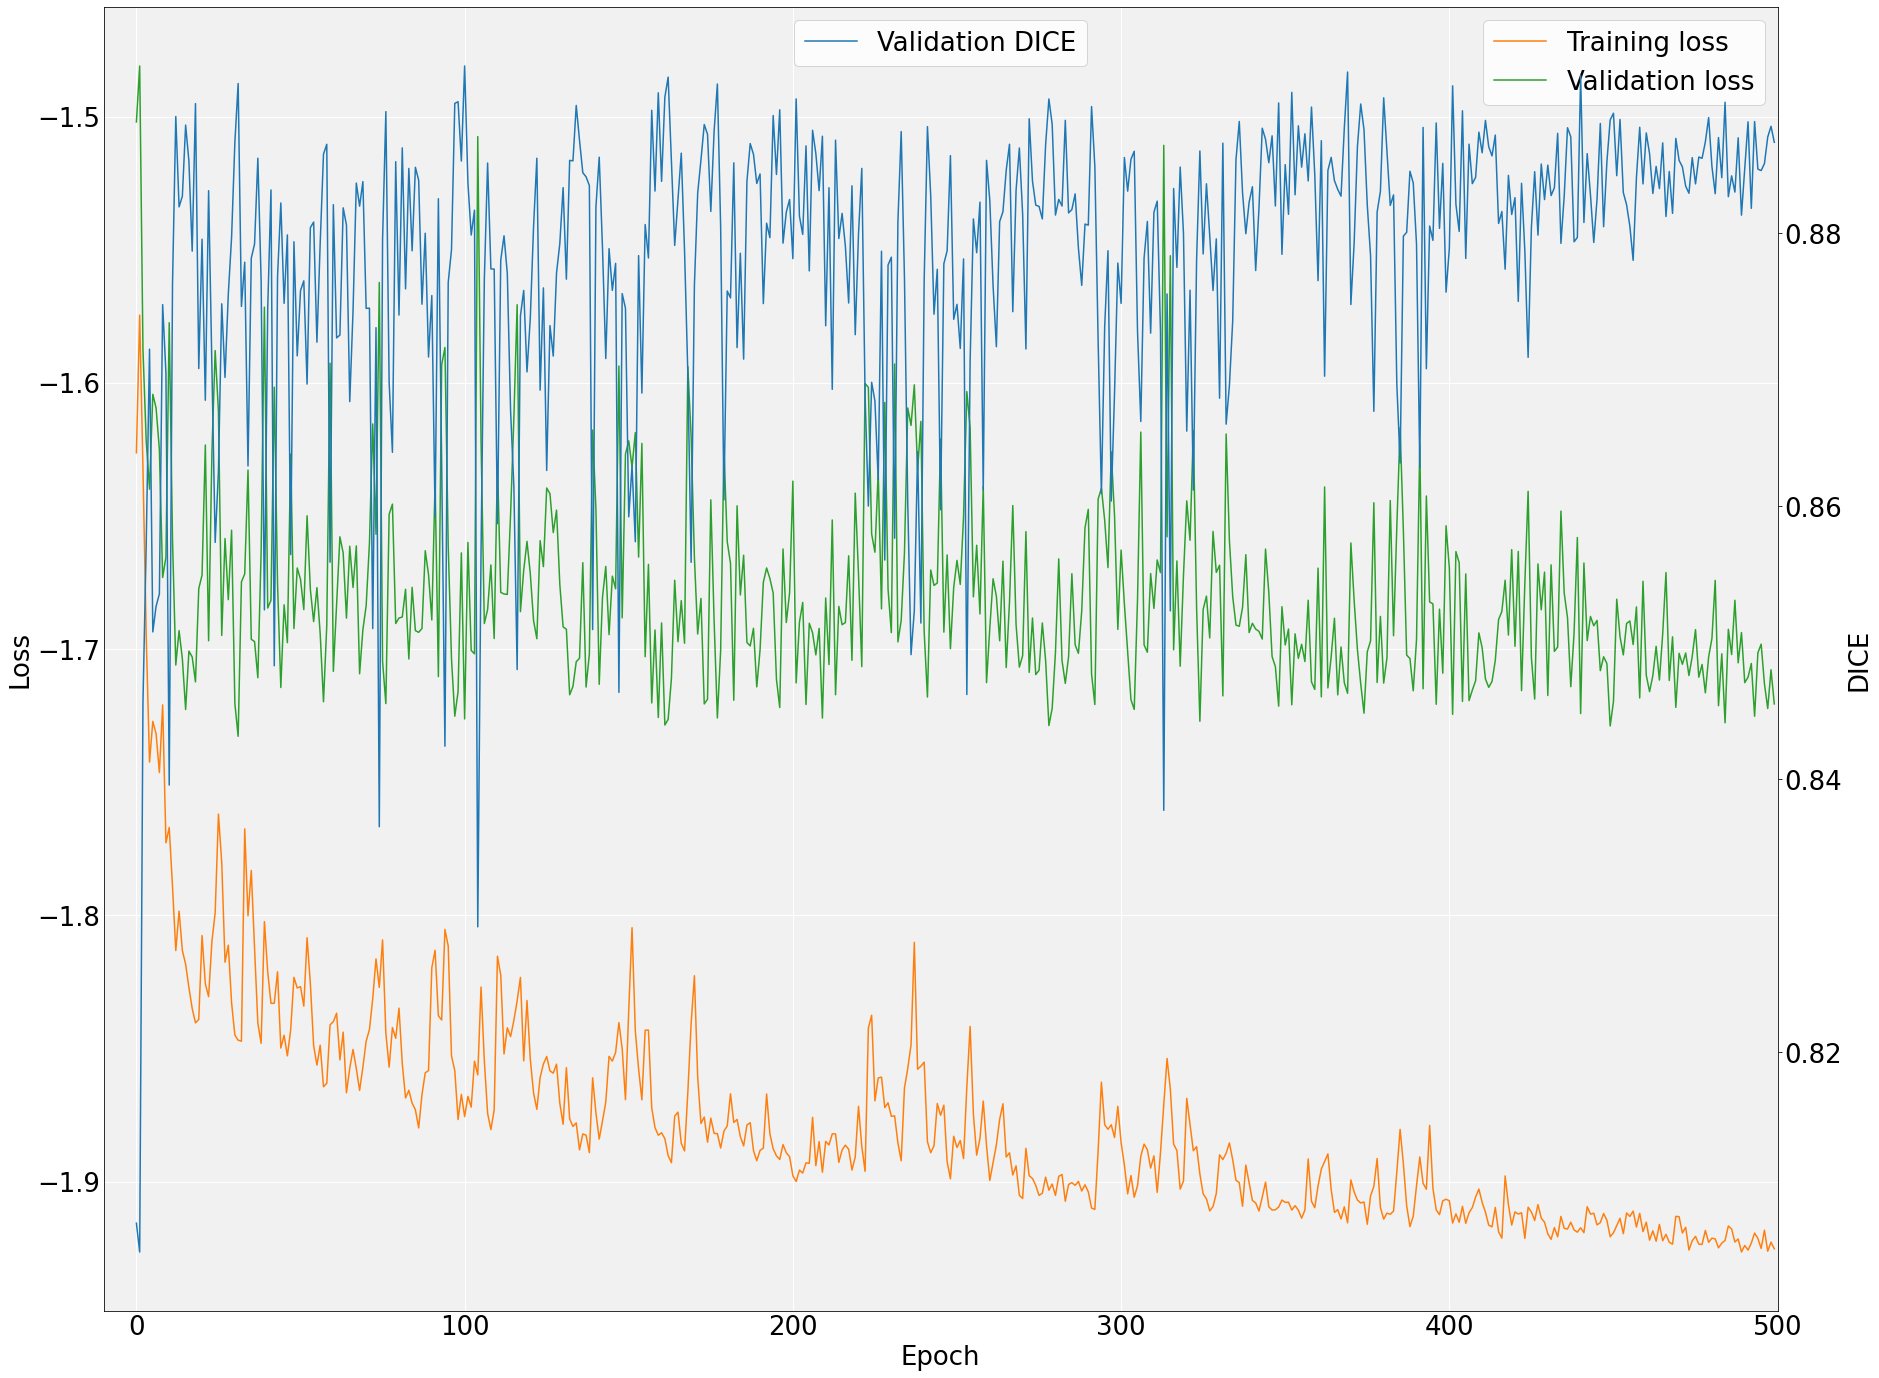

4


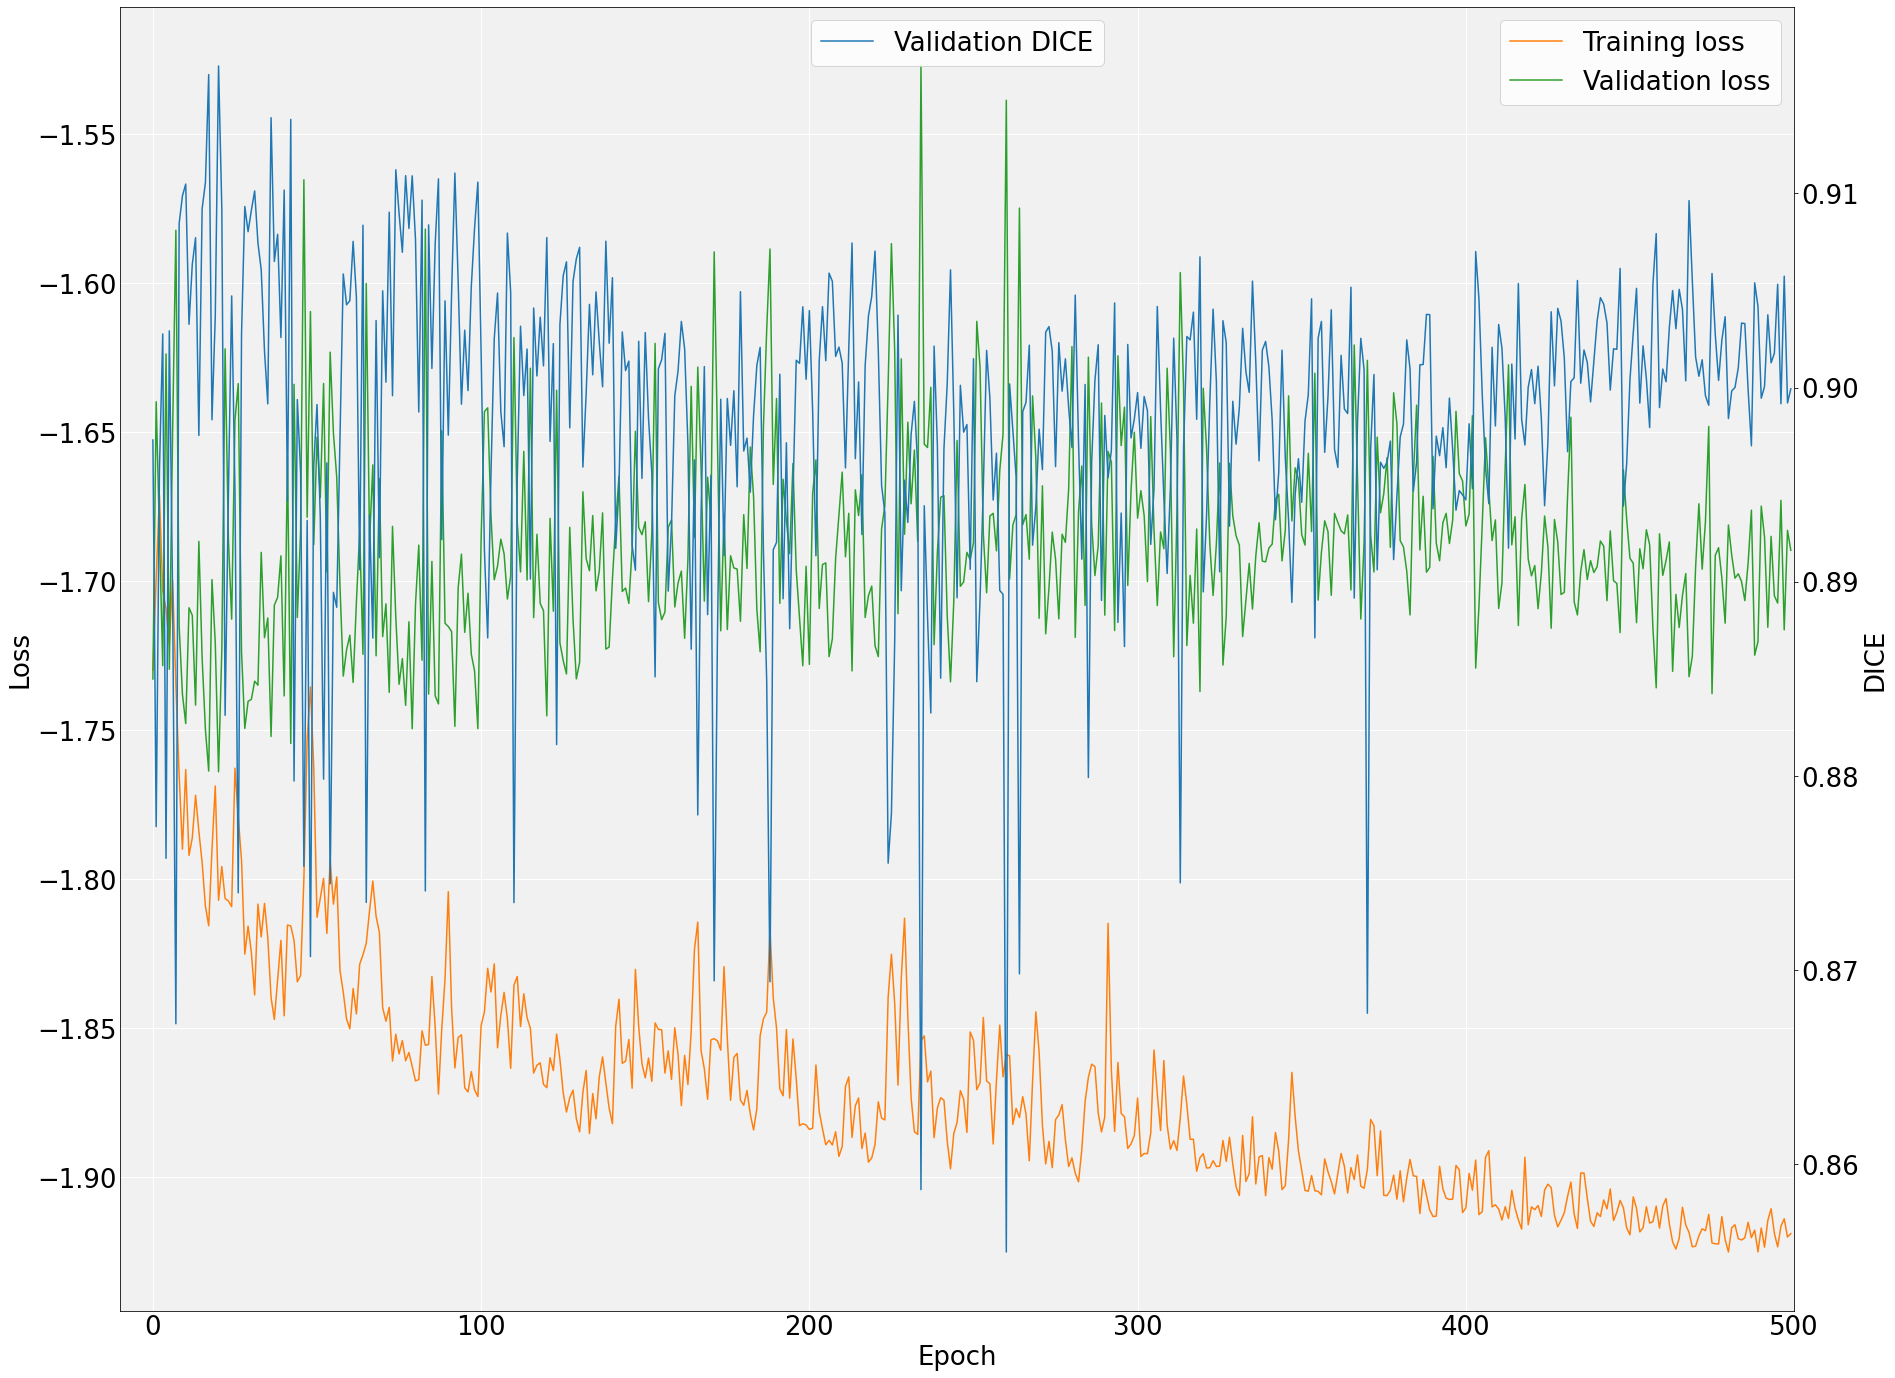

In [8]:
plt.rcParams.update({'font.size': 26})

# create convergence plots for each fold 
for fold in folds:
    print(fold)
    # load debug file for fold
    fold_path = create_fold_path(fold)
    debug = open(os.path.join(res_path, fold_path, "debug.json"))
    debug = json.load(debug)

    # load metrics
    tr_losses = mana.convert_string_array_to_list(debug["all_tr_losses"])
    val_losses = mana.convert_string_array_to_list(debug["all_val_losses"])
    val_metrics = mana.convert_string_array_to_list(debug["all_val_eval_metrics"])
    epochs = range(0,len(tr_losses))

    # plot
    fig, ax, ax2 = mana.get_plot_layout(True)
    ax2.plot(epochs, val_metrics, label="Validation DICE", c="C0", ls='-')
    ax.plot(epochs, tr_losses, label="Training loss", c="C1", ls='-')
    ax.plot(epochs, val_losses, label="Validation loss", c="C2", ls='-')
    ax.set_xlabel("Epoch")
    ax.set_xlim(-10,500)
    ax.set_ylabel("Loss")
    ax2.set_ylabel("DICE")
    ax.legend()
    ax2.legend(loc=9)
    plt.savefig(f"{fig_path}/convergence_single_fold_{task}_{config}_{trainer}_{fold}", dpi=300, figsize=(8,5))
    plt.show()


Analyse the DICE mean / std / max / min per fold and save

In [9]:
DICE = "Dice"
PRECISION = "Precision"
RECALL = "Recall"
FNR = "False Discovery Rate"
FDR = "False Negative Rate"

# create index
iterables = [folds, labels]
df = pd.DataFrame(columns=['Mean', 'Std', 'Max', 'Min'], index=pd.MultiIndex.from_product(iterables))

# get evaluation metrics from each single fold
for fold in folds:

    # load debug and summary file for fold
    fp = create_fold_path(fold)
    fold_path = os.path.join(res_path, fp)
    debug = open(os.path.join(fold_path, "debug.json"))
    summary = open(os.path.join(fold_path, "validation_raw_postprocessed", "summary.json"))
    debug = json.load(debug)
    summary = json.load(summary)["results"]

    # Show when and what the best validation metrics were
    best_epoch = debug["best_epoch_based_on_MA_tr_loss"]
    best_val = debug["best_val_eval_criterion_MA"]

    print(f"Fold {fold} had the best validation metric in epoch {best_epoch}: {best_val}")
    all = summary["all"]
    for label in labels:
        # Get the statistics per case
        dices = []
        for val in all:
            panc = val[str(label)]
            dices.append(panc[DICE])
        dices = np.array(dices)

        # Calculate the statistics for ourselves
        dices_mean, dices_std, dices_max, dices_min = np.nanmean(dices), np.nanstd(dices), np.nanmax(dices), np.nanmin(dices)


        # Get the calcualted metrics by nnUnet
        mean = summary["mean"][str(label)]
        mean_dice = mean[DICE]

        # SANITY CHECK if everything the same
        np.testing.assert_allclose(mean_dice, dices_mean, rtol=1e-5, atol=0)

        # Print and save everything
        print(f"{label} Mean DICE is {mean_dice} ({dices_std}), with a maximum of {dices_max} and minimum of {dices_min}\n")
        df.loc[(fold, label), :] = [dices_mean, dices_std, dices_max, dices_min]

df[['Mean', 'Std', 'Max', 'Min']] = df[['Mean', 'Std', 'Max', 'Min']].apply(pd.to_numeric)
df.to_csv(os.path.join(save_res_path, f'singlefolds_{config}_{trainer}.csv'), float_format='%.3f', sep=';')

Fold 0 had the best validation metric in epoch 496: 0.8781001728926195
1 Mean DICE is 0.8607881562391974 (0.08612471910371475), with a maximum of 0.9247724741753389 and minimum of 0.6747982459372812

Fold 1 had the best validation metric in epoch 499: 0.8652843770911613
1 Mean DICE is 0.8696876753378641 (0.02107699669124687), with a maximum of 0.9027669805073277 and minimum of 0.8452349999235276

Fold 2 had the best validation metric in epoch 492: 0.9021147276141672
1 Mean DICE is 0.9039552315497826 (0.03380415285665269), with a maximum of 0.9304514394120789 and minimum of 0.8315483753857325

Fold 3 had the best validation metric in epoch 495: 0.8855697932413061
1 Mean DICE is 0.8952853883857926 (0.022104962699387404), with a maximum of 0.9214383579350102 and minimum of 0.8580372173438282

Fold 4 had the best validation metric in epoch 489: 0.9048431888606313
1 Mean DICE is 0.8837286390930764 (0.06668999500743347), with a maximum of 0.9249265160403184 and minimum of 0.7518326048800633


In [10]:
for label in labels:
    lab = df.loc(axis=0)[pd.IndexSlice[:, label]]
    mean_mean = lab["Mean"].mean()
    print(f"Label {label} has mean {mean_mean*100}")
    print(lab)
    print("\n\n")

Label 1 has mean 88.26890181211427
         Mean       Std       Max       Min
0 1  0.860788  0.086125  0.924772  0.674798
1 1  0.869688  0.021077  0.902767  0.845235
2 1  0.903955  0.033804  0.930451  0.831548
3 1  0.895285  0.022105  0.921438  0.858037
4 1  0.883729  0.066690  0.924927  0.751833



